# Описание проекта

>Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

>Данные находятся в трёх файлах:
- **gold_recovery_train.csv** — обучающая выборка;
- **gold_recovery_test.csv** — тестовая выборка;
- **gold_recovery_full.csv** — исходные данные

> Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

# Описание данных

>Технологический процесс:
- **Rougher feed** — исходное сырье
- **Rougher additions (или reagent additions)** — флотационные реагенты:
    - Xanthate — ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- **Rougher process (англ. «грубый процесс»)** — флотация
- **Rougher tails** — отвальные хвосты
- **Cleaner process** — очистка
- **Rougher Au** — черновой концентрат золота
- **Final Au** — финальный концентрат золота

>Параметры этапов:
- **air amount** — объём воздуха
- **fluid levels** — уровень жидкости
- **feed size** — размер гранул сырья
- **feed rate**— скорость подачи

>Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]\
*Пример: rougher.input.feed_ag*

>Возможные значения для блока [этап]:
- **rougher** — флотация
- **primary_cleaner** — первичная очистка
- **secondary_cleaner** — вторичная очистка
- **final** — финальные характеристики

>Возможные значения для блока [тип_параметра]:
- **input** — параметры сырья
- **output** — параметры продукта
- **state** — параметры, характеризующие текущее состояние этапа
- **calculation** — расчётные характеристики


# Содержание

>[1. Подготовка даннных](#id-open) \
>[2. Анализ](#id-open) \
>[3. Предсказание](#id-predict) 

# 1. Загрузка и подготовка данных<a id="id-open"></a>

1. Подготовьте данные\
    1.1. Откройте файлы и изучите их.\
    1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.\
    1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?\
    1.4. Проведите предобработку данных.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np
import warnings
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
warnings.simplefilter('ignore')
from sklearn.metrics import make_scorer

In [2]:
train = pd.read_csv("")
test = pd.read_csv("")
full = pd.read_csv("")

In [3]:
train.shape

(16860, 87)

In [4]:
test.shape

(5856, 53)

In [5]:
full.shape

(22716, 87)

>Равно ли количество наблюдений тестовая+тренировочная выборка полной выборке?

In [6]:
train.shape[0] + test.shape[0] == full.shape[0]

True

>Какие колонки есть в тренировочной выборке, но нет в тестовой?

In [7]:
np.setdiff1d(train.columns, test.columns)

array(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag',
       'final.output.tail_au', 'final.output.tail_pb',
       'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       

>В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, т.к. их невозможно получить/измерить во время выполнения технологического процесса. 

>Есть ли различия в колонках между тренировочной и полной выборкой?

In [8]:
np.setdiff1d(train.columns, full.columns)

array([], dtype=object)

>Рассчитаем значение MAE на тренировочной выборке

In [9]:
def recovery(C,F,T):
    return (C*(F - T))/(F*(C - T))*100

In [10]:
train["rougher.output.recovery.check"] = recovery(train["rougher.output.concentrate_au"],
                                                  train["rougher.input.feed_au"], 
                                                  train["rougher.output.tail_au"])

In [11]:
train_mae_calc = train[["rougher.output.recovery.check","rougher.output.recovery"]].dropna()

In [12]:
train_mae_calc.shape

(14287, 2)

In [13]:
mean_absolute_error(train_mae_calc["rougher.output.recovery"], train_mae_calc["rougher.output.recovery.check"])

9.444891926100695e-15

In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,16788.0,4.716907,2.096718e+00,0.000000e+00,3.971262,4.869346,5.821176,1.600195e+01
final.output.concentrate_pb,16788.0,9.113559,3.389495e+00,0.000000e+00,8.825748,10.065316,11.054809,1.703190e+01
final.output.concentrate_sol,16490.0,8.301123,3.825760e+00,0.000000e+00,6.939185,8.557228,10.289741,1.812485e+01
final.output.concentrate_au,16789.0,39.467217,1.391723e+01,0.000000e+00,42.055722,44.498874,45.976222,5.361137e+01
final.output.recovery,15339.0,67.213166,1.196045e+01,0.000000e+00,62.625685,67.644601,72.824595,1.000000e+02
final.output.tail_ag,16794.0,8.757048,3.634103e+00,0.000000e+00,7.610544,9.220393,10.971110,1.955215e+01
final.output.tail_pb,16677.0,2.360327,1.215576e+00,0.000000e+00,1.641604,2.453690,3.192404,6.086532e+00
final.output.tail_sol,16715.0,9.303932,4.263208e+00,0.000000e+00,7.870275,10.021968,11.648573,2.231773e+01
final.output.tail_au,16794.0,2.687512,1.272757e+00,0.000000e+00,2.172953,2.781132,3.416936,9.789625e+00
primary_cleaner.input.sulfate,15553.0,129.479789,4.538693e+01,2.567664e-06,103.064021,131.783108,159.539839,2.519999e+02


In [15]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5554.0,170.515243,49.608602,0.000103,143.340022,176.103893,207.240761,274.409626
primary_cleaner.input.depressant,5572.0,8.482873,3.353105,0.000031,6.411500,8.023252,10.017725,40.024582
primary_cleaner.input.feed_size,5856.0,7.264651,0.611526,5.650000,6.885625,7.259333,7.650000,15.500000
primary_cleaner.input.xanthate,5690.0,1.321420,0.693246,0.000003,0.888769,1.183362,1.763797,5.433169
primary_cleaner.state.floatbank8_a_air,5840.0,1481.990241,310.453166,0.000000,1497.190681,1554.659783,1601.681656,2212.432090
primary_cleaner.state.floatbank8_a_level,5840.0,-509.057796,61.339256,-799.773788,-500.455211,-499.997402,-499.575313,-57.195404
primary_cleaner.state.floatbank8_b_air,5840.0,1486.908670,313.224286,0.000000,1497.150234,1553.268084,1601.784707,1975.147923
primary_cleaner.state.floatbank8_b_level,5840.0,-511.743956,67.139074,-800.029078,-500.936639,-500.066588,-499.323361,-142.527229
primary_cleaner.state.floatbank8_c_air,5840.0,1468.495216,309.980748,0.000000,1437.050321,1546.160672,1600.785573,1715.053773
primary_cleaner.state.floatbank8_c_level,5840.0,-509.741212,62.671873,-799.995127,-501.300441,-500.079537,-499.009545,-150.937035


In [16]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5554.0,170.515243,49.608602,0.000103,143.340022,176.103893,207.240761,274.409626
primary_cleaner.input.depressant,5572.0,8.482873,3.353105,0.000031,6.411500,8.023252,10.017725,40.024582
primary_cleaner.input.feed_size,5856.0,7.264651,0.611526,5.650000,6.885625,7.259333,7.650000,15.500000
primary_cleaner.input.xanthate,5690.0,1.321420,0.693246,0.000003,0.888769,1.183362,1.763797,5.433169
primary_cleaner.state.floatbank8_a_air,5840.0,1481.990241,310.453166,0.000000,1497.190681,1554.659783,1601.681656,2212.432090
primary_cleaner.state.floatbank8_a_level,5840.0,-509.057796,61.339256,-799.773788,-500.455211,-499.997402,-499.575313,-57.195404
primary_cleaner.state.floatbank8_b_air,5840.0,1486.908670,313.224286,0.000000,1497.150234,1553.268084,1601.784707,1975.147923
primary_cleaner.state.floatbank8_b_level,5840.0,-511.743956,67.139074,-800.029078,-500.936639,-500.066588,-499.323361,-142.527229
primary_cleaner.state.floatbank8_c_air,5840.0,1468.495216,309.980748,0.000000,1437.050321,1546.160672,1600.785573,1715.053773
primary_cleaner.state.floatbank8_c_level,5840.0,-509.741212,62.671873,-799.995127,-501.300441,-500.079537,-499.009545,-150.937035


In [17]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery.check
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629

In [18]:
test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [19]:
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

>Заполним пустые значения с помощью функции ffill в тренировочной и тестовой выборках.

In [20]:
train.ffill(inplace=True)

In [21]:
train.head(60)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery.check
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629

In [22]:
sum(train.isna().sum())

0

In [23]:
test.ffill(inplace=True)

In [24]:
sum(test.isna().sum())

0

>В тестовую выборку добавим целевые колонки из полной выборки

In [25]:
test = test.set_index("date")

In [26]:
train = train.set_index("date")

In [27]:
full = full.set_index("date")

In [28]:
test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289

In [29]:
full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [30]:
full[full.index == "2016-09-01 00:59:59"]["rougher.output.recovery"]

date
2016-09-01 00:59:59    89.993421
Name: rougher.output.recovery, dtype: float64

In [31]:
full_recoveries = full.loc[:, ['rougher.output.recovery', 'final.output.recovery']]

In [32]:
test = test.merge(full_recoveries, left_index=True, right_index=True)

In [33]:
test[test.index == "2016-09-01 00:59:59"]["rougher.output.recovery"]

date
2016-09-01 00:59:59    89.993421
Name: rougher.output.recovery, dtype: float64

>Из тренировочной выборки удалим все колонки, которых нет в тестовой выборке.

In [34]:
diff_full = list(np.setdiff1d(train.columns, test.columns))

In [35]:
train = train.drop(diff_full, axis=1)

In [36]:
train.shape

(16860, 54)

In [37]:
test.shape

(5856, 54)

# Выводы раздел 1

- В исходых данных 3 файла - полная выборка и тестовая+тренировачная выборки. Количество наблюдений полной выборки совпадает с количеством наблюдений тестовая+тренировочная выборки.
- Переменные final.output.recovery и rougher.output.recovery являются целевыми.
- В тестовой выборке отсутствует ряд колонок - параметры, которые замеряются и/или рассчитываются значительно позже и целевые колонки.
- Расчетное значение rougher.output.recovery получилось очень близким к значению в тренировочной выборке (MAE очень маленькая). Значит значение в тренировочной выборке рассчитано верно. 
- По условиям задачи данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Поэтому в тестовой и тренировочной выборке заполнила пустые значения функцией ffill.
- В тестовую выборку добавила целевые колонки из полной выборки.
- Из тренировочной выборки удалила колонки, которые отсутствуют в тестовой выборке.

# 2. Проанализируйте данные<a id="id-open"></a>

2. Проанализируйте данные\
    2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.\
    2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.\
    2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

>2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

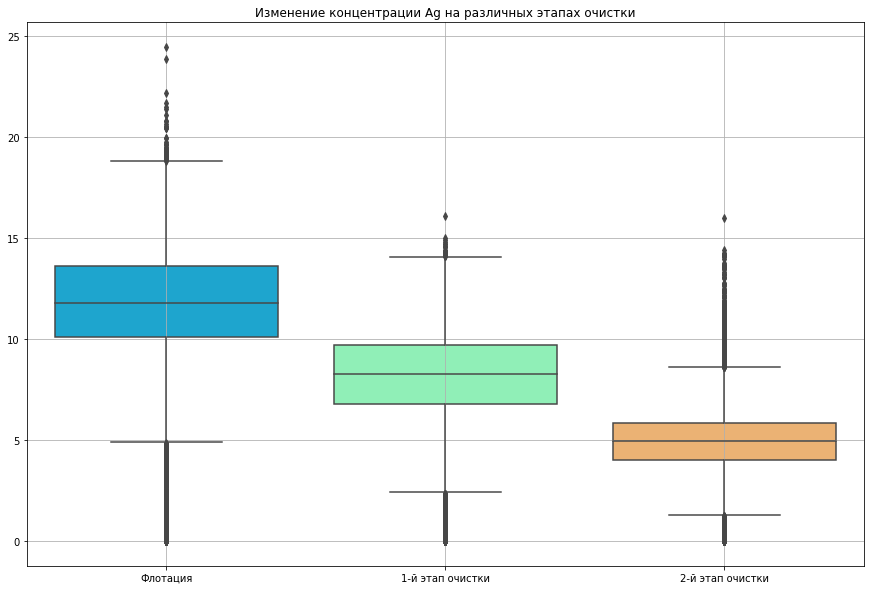

In [38]:
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=full[["rougher.output.concentrate_ag",  
                            "primary_cleaner.output.concentrate_ag",  
                            "final.output.concentrate_ag"]], palette='rainbow')
ax.set_title("Изменение концентрации Ag на различных этапах очистки")
plt.xticks([0, 1, 2], ['Флотация', '1-й этап очистки', '2-й этап очистки'])
plt.grid(True);

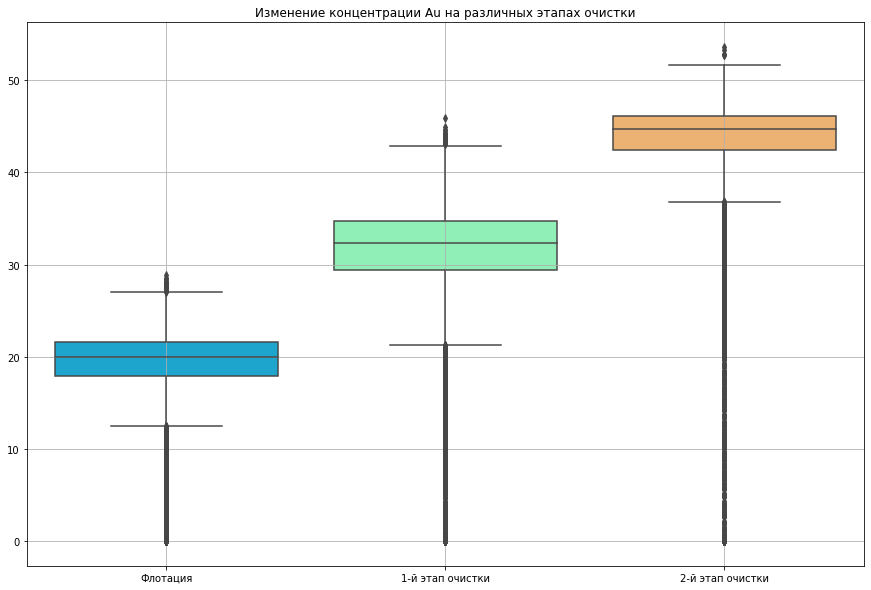

In [39]:
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=full[["rougher.output.concentrate_au",  
                            "primary_cleaner.output.concentrate_au",  
                            "final.output.concentrate_au"]], palette='rainbow')
ax.set_title("Изменение концентрации Au на различных этапах очистки")
plt.xticks([0, 1, 2], ['Флотация', '1-й этап очистки', '2-й этап очистки'])
plt.grid(True);

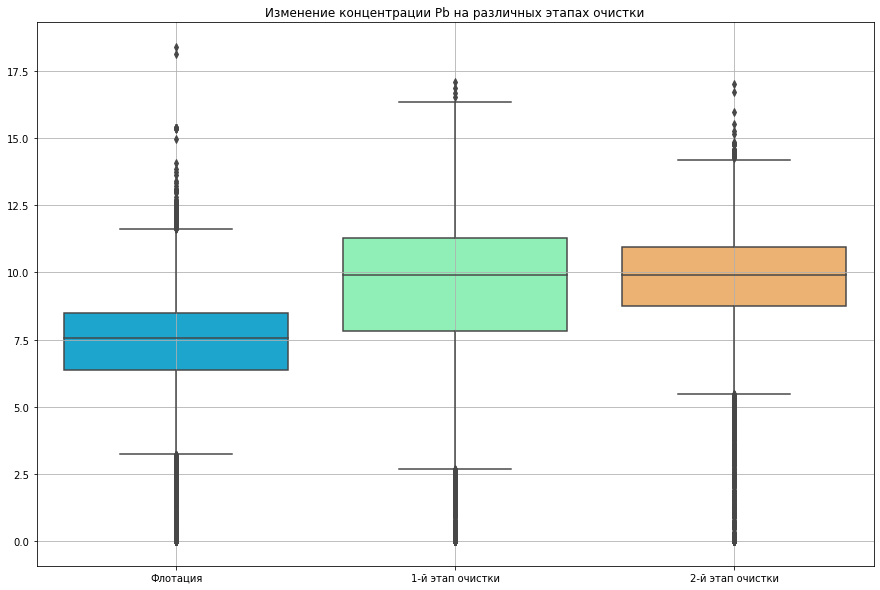

In [40]:
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=full[["rougher.output.concentrate_pb",  
                            "primary_cleaner.output.concentrate_pb",  
                            "final.output.concentrate_pb"]], palette='rainbow')
ax.set_title("Изменение концентрации Pb на различных этапах очистки")
plt.xticks([0, 1, 2], ['Флотация', '1-й этап очистки', '2-й этап очистки'])
plt.grid(True);

>2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

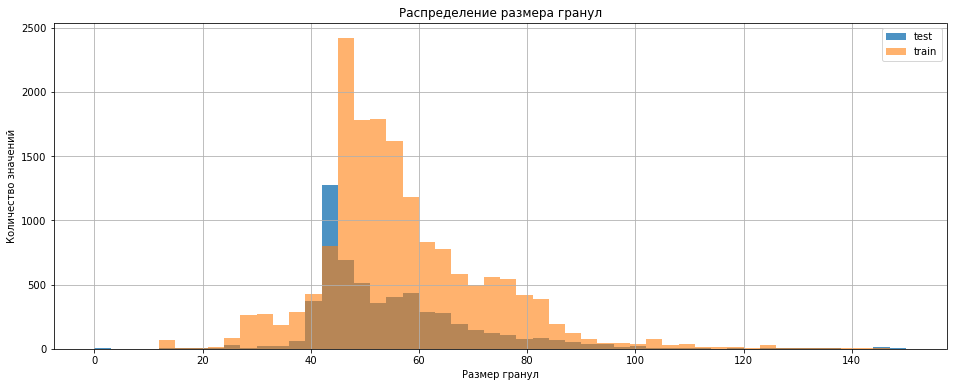

In [41]:
figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
test["rougher.input.feed_size"].hist(alpha=0.8, bins=50, range=(0,150))
train["rougher.input.feed_size"].hist(alpha=0.6, bins=50, range=(0,150))
plt.title("Распределение размера гранул")
plt.xlabel("Размер гранул")
plt.ylabel("Количество значений")
plt.legend(["test", "train"])
plt.grid(True)
plt.show()

>2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

In [42]:
full_metals = full.loc[:, ["rougher.output.concentrate_pb", 
                           "primary_cleaner.output.concentrate_pb",
                           "final.output.concentrate_pb", 
                           "rougher.output.concentrate_au", 
                           "primary_cleaner.output.concentrate_au", 
                           "final.output.concentrate_au", 
                           "rougher.output.concentrate_ag", 
                           "primary_cleaner.output.concentrate_ag", 
                           "final.output.concentrate_ag"]]

In [43]:
train = train.merge(full_metals,  left_index=True, right_index=True )

In [44]:
train["sum_metal"] = train["rougher.output.concentrate_pb"] + \
                train["primary_cleaner.output.concentrate_pb"] + \
                train["final.output.concentrate_pb"] + \
                train["rougher.output.concentrate_au"] + \
                train["primary_cleaner.output.concentrate_au"] + \
                train["final.output.concentrate_au"] + \
                train["rougher.output.concentrate_ag"] + \
                train["primary_cleaner.output.concentrate_ag"] + \
                train["final.output.concentrate_ag"] 

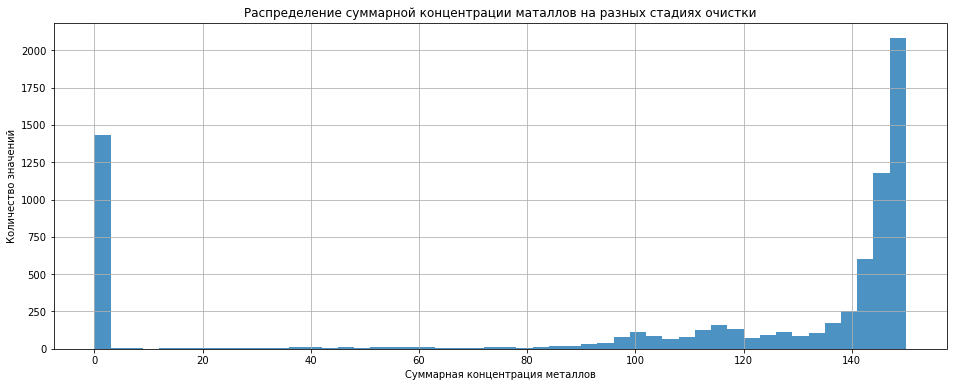

In [45]:
figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
train["sum_metal"].hist(alpha=0.8, bins=50, range=(0,150))
plt.title("Распределение суммарной концентрации маталлов на разных стадиях очистки")
plt.xlabel("Суммарная концентрация металлов")
plt.ylabel("Количество значений")
plt.grid(True)
plt.show()

In [46]:
train = train.query("sum_metal != 0")

In [47]:
train.shape

(15781, 64)

In [48]:
test.shape

(5856, 54)

In [49]:
test = test.merge(full_metals, on="date", how="inner" )

In [50]:
test["sum_metal"] = test["rougher.output.concentrate_pb"] + \
                        test["primary_cleaner.output.concentrate_pb"] + \
                        test["final.output.concentrate_pb"] + \
                        test["rougher.output.concentrate_au"] + \
                        test["primary_cleaner.output.concentrate_au"] + \
                        test["final.output.concentrate_au"] + \
                        test["rougher.output.concentrate_ag"] + \
                        test["primary_cleaner.output.concentrate_ag"] + \
                        test["final.output.concentrate_ag"] 

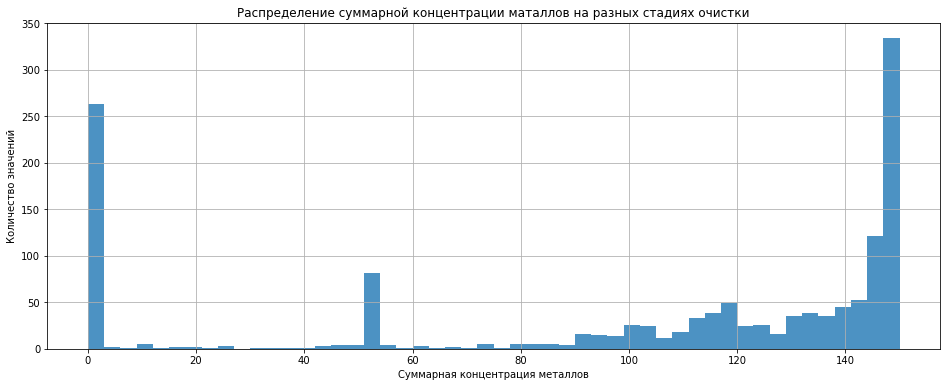

In [51]:
figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
test["sum_metal"].hist(alpha=0.8, bins=50, range=(0,150))
plt.title("Распределение суммарной концентрации маталлов на разных стадиях очистки")
plt.xlabel("Суммарная концентрация металлов")
plt.ylabel("Количество значений")
plt.grid(True)
plt.show()

In [52]:
test = test.query("sum_metal != 0")

In [53]:
test.shape

(5595, 64)

In [54]:
full["sum_metal"] = full["rougher.output.concentrate_pb"] + \
                        full["primary_cleaner.output.concentrate_pb"] + \
                        full["final.output.concentrate_pb"] + \
                        full["rougher.output.concentrate_ag"] + \
                        full["primary_cleaner.output.concentrate_ag"] + \
                        full["final.output.concentrate_ag"] + \
                        full["rougher.output.concentrate_pb"] + \
                        full["primary_cleaner.output.concentrate_pb"] + \
                        full["final.output.concentrate_pb"]  

In [55]:
full.shape

(22716, 87)

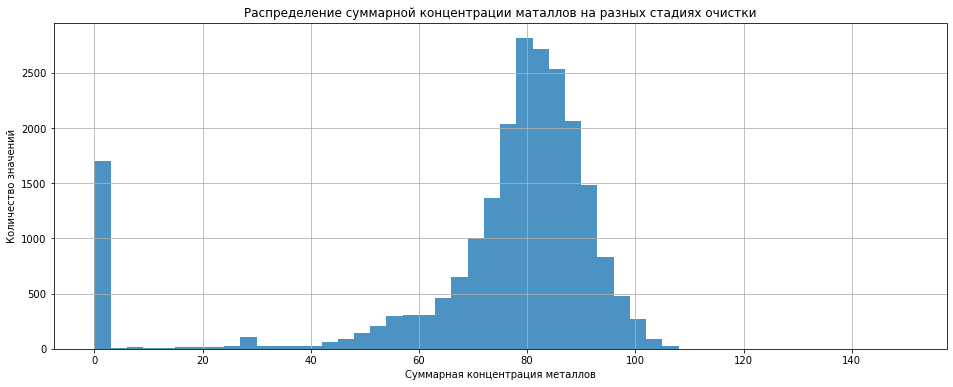

In [56]:
figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
full["sum_metal"].hist(alpha=0.8, bins=50, range=(0,150))
plt.title("Распределение суммарной концентрации маталлов на разных стадиях очистки")
plt.xlabel("Суммарная концентрация металлов")
plt.ylabel("Количество значений")
plt.grid(True)
plt.show()

In [57]:
full = full.query("sum_metal != 0")

In [58]:
X_train = train.drop(["rougher.output.concentrate_pb", 
                      "primary_cleaner.output.concentrate_pb", "final.output.concentrate_pb", 
                      "rougher.output.concentrate_au", "primary_cleaner.output.concentrate_au", 
                      "final.output.concentrate_au", "rougher.output.concentrate_ag", 
                      "primary_cleaner.output.concentrate_ag", "final.output.concentrate_ag", 
                      "final.output.recovery", "sum_metal", "rougher.output.recovery"], axis=1)

In [59]:
y_train_rougher = train["rougher.output.recovery"]

In [60]:
y_train_final = train["final.output.recovery"]

In [61]:
X_test = test.drop(["rougher.output.concentrate_pb", 
                    "primary_cleaner.output.concentrate_pb", 
                    "final.output.concentrate_pb", 
                    "rougher.output.concentrate_au", 
                    "primary_cleaner.output.concentrate_au", 
                    "final.output.concentrate_au", 
                    "rougher.output.concentrate_ag", 
                    "primary_cleaner.output.concentrate_ag", 
                    "final.output.concentrate_ag", 
                    "final.output.recovery", 
                    "sum_metal", 
                    "rougher.output.recovery"], axis=1)

In [62]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5595 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5595 non-null   float64
 1   primary_cleaner.input.depressant            5595 non-null   float64
 2   primary_cleaner.input.feed_size             5595 non-null   float64
 3   primary_cleaner.input.xanthate              5595 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5595 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5595 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5595 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5595 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5595 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5595 non-null

In [63]:
y_test_rougher = test["rougher.output.recovery"]

In [64]:
y_test_final = test["final.output.recovery"]

# Выводы раздел 2

- Концентрация Au по мере продвижени очистки увеличивается - это соответсвует физическому миру - чем дальше мы продвигаемся в ходе очистки, тем больше становится доля золота в массе сырья. Концентрация Ag снижается - что также логично - посторонние металлы очищаются. Концертрация pb не снижается - pb побочный продукт химических реакций.
- Визуально распределение гранул сырья на обучающей и тестовой выборках очень схоже. Оценка моделей будет верной.
- Суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах в некоторых строках равно нулю, что скоррее всего является некорректным.  Аномалии удалили.

# 3. Предсказание <a id="id-open"></a>

3.1. Напишите функцию для вычисления итоговой sMAPE.\
3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [65]:
def smape(y, y_pred):
    num = abs(y-y_pred)
    denom = ((abs(y) + abs(y_pred)))/2
    frac = num/denom
    n = 1/len(y)
    return n * frac.sum() * 100

In [66]:
def smapefinal(smape_rougher, smape_final):
    return smape_rougher*0.25 + smape_final*0.75

In [67]:
scorer = make_scorer(smape, greater_is_better = False)

# LinearRegression

In [68]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [69]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
params = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

### rougher

In [72]:
model = LinearRegression()

In [73]:
clf = GridSearchCV(estimator=model, param_grid =params,  cv=3,  n_jobs=-1, scoring=scorer)
clf.fit(X_train_scaled, y_train_rougher)

GridSearchCV(cv=3, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(smape, greater_is_better=False))

In [74]:
y_pred=clf.predict(X_test_scaled)

In [75]:
smape_rougher = smape(y_test_rougher, y_pred)

In [76]:
smape_rougher

9.192830433223497

### Final

In [77]:
model = LinearRegression()

In [78]:
clf = GridSearchCV(estimator=model, param_grid =params,  cv=3,  n_jobs=-1, scoring=scorer)
clf.fit(X_train_scaled, y_train_final)

GridSearchCV(cv=3, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(smape, greater_is_better=False))

In [79]:
y_pred=clf.predict(X_test_scaled)

In [80]:
smape_final = smape(y_test_final, y_pred)

### Result linear regression

In [81]:
smapefinal(smape_rougher, smape_final)

9.990295459375325

# DecisionTree

In [82]:
params = {'min_samples_leaf': list(range(2,21)),
    'min_samples_split': list(range(2,6)),
    'max_depth' : list(range(2,11))}

### Rougher

In [83]:
model = DecisionTreeRegressor()

In [84]:
clf = GridSearchCV(estimator=model, param_grid =params,  cv=3,  n_jobs=-1, scoring=scorer)
clf.fit(X_train, y_train_rougher)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring=make_scorer(smape, greater_is_better=False))

In [85]:
y_pred=clf.predict(X_test)

In [86]:
smape_rougher = smape(y_test_rougher, y_pred)

### Final

In [87]:
model = DecisionTreeRegressor()

In [88]:
clf = GridSearchCV(estimator=model, param_grid =params,  cv=3,  n_jobs=-1, scoring=scorer)
clf.fit(X_train, y_train_final)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring=make_scorer(smape, greater_is_better=False))

In [89]:
y_pred=clf.predict(X_test)

In [90]:
smape_final = smape(y_test_final, y_pred)

### Result decision tree

In [91]:
smapefinal(smape_rougher, smape_final)

9.782393705884525

# RandomForest

In [92]:
params = { 
    'n_estimators': [10, 50, 100],
    'max_depth' : [5, 7, 10]}

### Rougher

In [93]:
model = RandomForestRegressor()

In [94]:
clf = GridSearchCV(estimator=model, param_grid =params,  cv=3,  n_jobs=-1, scoring=scorer)
clf.fit(X_train, y_train_rougher)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10],
                         'n_estimators': [10, 50, 100]},
             scoring=make_scorer(smape, greater_is_better=False))

In [95]:
y_pred=clf.predict(X_test)

In [96]:
smape_rougher = smape(y_test_rougher, y_pred)

### Final

In [97]:
model = RandomForestRegressor()

In [98]:
clf = GridSearchCV(estimator=model, param_grid =params,  cv=3,  n_jobs=-1, scoring=scorer)
clf.fit(X_train, y_train_final)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10],
                         'n_estimators': [10, 50, 100]},
             scoring=make_scorer(smape, greater_is_better=False))

In [99]:
y_pred=clf.predict(X_test)

In [100]:
smape_final = smape(y_test_final, y_pred)

### Result random forest

In [101]:
smapefinal(smape_rougher, smape_final)

10.16950538807359

### Базовая модель

In [102]:
y_rougher_const = pd.Series(y_train_rougher.median(), index=y_test_rougher.index)
y_final_const = pd.Series(y_train_final.median(), index=y_test_final.index)

In [103]:
smape_rougher = smape(y_test_rougher, y_rougher_const)
smape_final = smape(y_final_const, y_test_final)

In [104]:
smapefinal(smape_rougher, smape_final)

9.754620523165595

# Выводы раздел 3 <a id="id-open"></a>

- Самую маленькую ошибку на метрике smape_final показала модель, обученная с помощью линейной регрессии. 
- Если взять за бейзлайн модель, которая предсказывает медиану, тогда ошибка получается немного меньше, чем у нашей лучшей модели 9.75 против 9.78 у decision tree.